<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/torch/notebooks/CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** **Description:** This notebook demonstrates how to train the generator network (Section 4.2, [Scalable particle-based alternatives to EM](https://juankuntz.github.io/publication/parem/)) on the CelebA dataset using PGD.

# Setup

First, we install and import the necessary modules, and we set three paths:

* `GDRIVE_CELEBA_PATH`: Path to the zipped `img_align_celeba.zip` file in the CelebA dataset. Please download it from the [source](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ).
* `LOCAL_CELEBA_DIR_PATH`: Directory where `img_align_celeba.zip` will be unzipped.
* `CHECKPOINTS_PATH`: Directory where we will save model checkpoints.

(To run the notebook locally, comment out the 'Colab setup' cell and uncomment the 'Local setup' cell.)

##  Colab setup

In [ ]:
%%capture
# Install missing packages
!pip install torchtyping
!pip install wandb
!pip install torchmetrics[image]

#from pathlib import Path
from google.colab import drive

# Import custom modules
import sys
from pathlib import Path
CHECKPOINTS_PATH = Path('/content/gdrive/MyDrive/ParEM/celeba/checkpoints')

!rm -rf ParEM
!git clone https://github.com/juankuntz/ParEM.git
REPOSITORY_PATH = '/content/ParEM/torch'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

drive.mount("/content/gdrive", force_remount=False)
DRIVE_CELEBA_ZIP_PATH = Path("/content/gdrive/MyDrive/datasets/celeba/img_align_celeba.zip")
LOCAL_CELEBA_DIR_PATH = Path("/content/") / "celeba"
assert DRIVE_CELEBA_ZIP_PATH.is_file()
if not LOCAL_CELEBA_DIR_PATH.is_dir():
  !cp $DRIVE_CELEBA_ZIP_PATH -d /content/
  !unzip /content/img_align_celeba.zip -d $LOCAL_CELEBA_DIR_PATH

## Local setup

In [ ]:
# import sys
# REPOSITORY_PATH = "../"
# if REPOSITORY_PATH not in sys.path:
#     sys.path.append(REPOSITORY_PATH)
# CHECKPOINTS_PATH = Path('./checkpoints')
# DRIVE_CELEBA_ZIP_PATH = 'PATH_TO_img_align_celeba.zip'
# LOCAL_CELEBA_DIR_PATH = 'LOCATION_WHERE_TO_UNZIP'
# if not LOCAL_CELEBA_DIR_PATH.is_dir():
#   !unzip $DRIVE_CELEBA_ZIP_PATH -d $LOCAL_CELEBA_DIR_PATH

## General setup

In [ ]:
# Import standard modules
import torch
import numpy as np
import matplotlib.pyplot as plt

# Import custom modules
from parem.models import NLVM
from parem.algorithms import (PGD,
                              ShortRun,
                              VI,
                              AlternatingBackprop)
from parem.utils import get_celeba, load_checkpoint

# Config variables and load dataset

Next, we set the config variables (the current values are set so that the notebook runs quickly; see Appendix F.3 for the values used to generate the results presented in the paper):

In [ ]:
# Data setttings
N_IMAGES = 10000  # M: training set size 

# Training settings
N_BATCH = 128 # M_b: batch size for theta updates
N_EPOCHS = 100 # n_epochs = K * M_b / M where K = total number of iterations
SEED = 1 # Seed for PRNG
# Device on which to carry out computations:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OPTIMIZER = 'rmsprop'  # Theta optimizer

# Model Settings
X_DIM = 64  # d_x: dimension of latent space
LIKELIHOOD_VAR = 0.01 ** 2  # sigma^2

# PGD Settings
STEP_SIZE = 1e-4 # h: step size 
LAMBDA = 1e-3 / (STEP_SIZE * N_IMAGES)  # lambda
N_PARTICLES = 10 # N: number of particles

And we load the CelebA dataset:

In [ ]:
dataset = get_celeba(LOCAL_CELEBA_DIR_PATH / "img_align_celeba", N_IMAGES)  # Load dataset

..................................................Total number of images 10000


# Define model and training algorithm

In this notebook, we use PGD to train the generator network. We implemented the algorithm in the class `PGD'. We also implemented the baselines in the paper via their own classes:

* [Short Run MCMC](https://arxiv.org/abs/1912.01909) in a class called `ShortRun`.
* [Variational autoencoder](https://arxiv.org/pdf/1312.6114.pdf) in a class called `VI`.
* [Alternating Backpropagation](https://arxiv.org/abs/1606.08571) in a class called `AlternatingBackprop`.

The interface is similar to that of `PGD`, see `torch/parem/algorithm` for details..

In [ ]:
# Define generator network as an instance of the NLVM (Neural Latent Variable 
# Model) class:
model = NLVM(x_dim=X_DIM, sigma2=LIKELIHOOD_VAR, nc=3).to(DEVICE)

# Define training algorithm:
pgd = PGD(model=model, lambd=LAMBDA, dataset=dataset, train_batch_size=N_BATCH,
          particle_step_size=STEP_SIZE, device=DEVICE, n_particles=N_PARTICLES,
          theta_optimizer=OPTIMIZER)

# Train

We train the model by calling the `run(...)` method of the `PGD` class (similarly for `ShortRun`, `VI`, and `AlternatingBackprop`). To track the training use the method's options:

* `wandb_log`: Use [Weights and Biases](https://wandb.ai/site) to log the training.
* `log_images`: Use [Weights and Biases](https://wandb.ai/site) to log images produced by model.
* `compute_stats`: Compute FID and MSE metrics throughout training.

In [ ]:
pgd.run(N_EPOCHS, CHECKPOINTS_PATH / '/celeba_vae1.pt', compute_stats=False, wandb_log=False, log_images=False)

...............................................................................Epoch 0: Loss 5638247.019,
...............................................................................Epoch 1: Loss 4682330.807,
...............................................................................Epoch 2: Loss 3264070.544,
...............................................................................Epoch 3: Loss 2182609.358,
...............................................................................Epoch 4: Loss 1709386.206,
...............................................................................Epoch 5: Loss 1464242.324,
...............................................................................Epoch 6: Loss 1344412.612,
...............................................................................Epoch 7: Loss 1231417.976,
...............................................................................Epoch 8: Loss 1142191.091,
..............................................

# Show particle cloud

To visualize the particle cloud we call `PGD.sample_image_posterior(i, n)` (similarly for `ShortRun`, `VI`, and `AlternatingBackprop`). It displays the `i`th image in the training set (first panel) and the images obtained by mapping the latent variables corresponding to this image and particles `1,2,...,n` through the trained generator network (ensuing `n` panels).

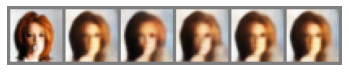

In [ ]:
pgd.sample_image_posterior(10, 5)

# Inpainting masked images

Calling `PGD.reconstruct(img, mask=None)`, we obtain the reconstruction of `img` generated by the trained network. If `mask` is not `None`, then we pass to the network a partially occluded image and it imputes the missing pixels (specified by the `mask`).

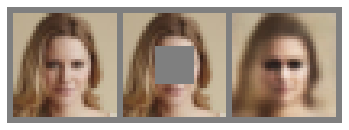

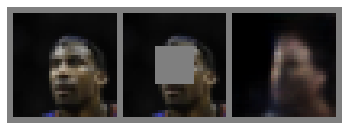

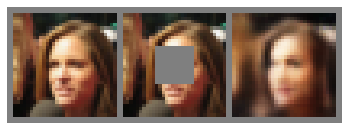

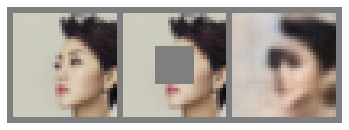

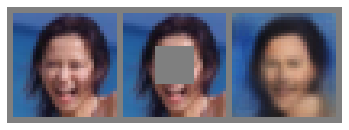

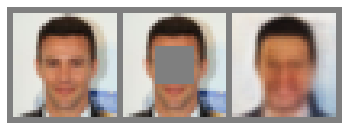

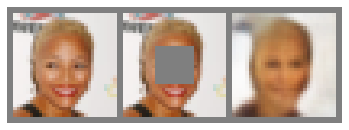

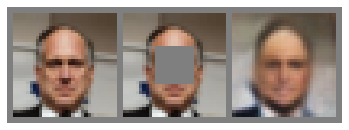

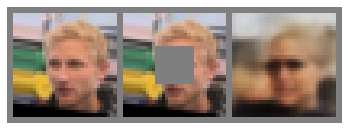

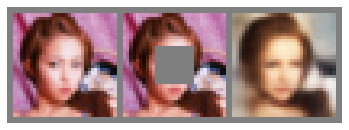

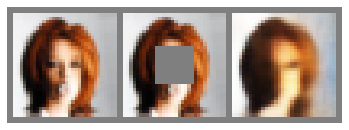

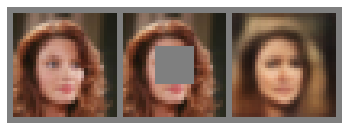

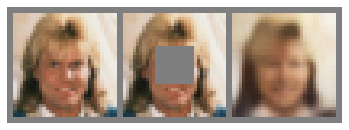

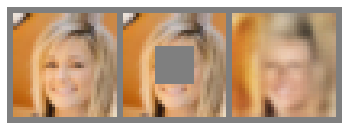

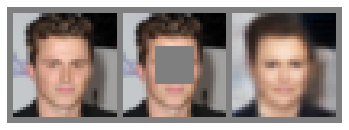

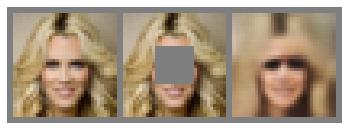

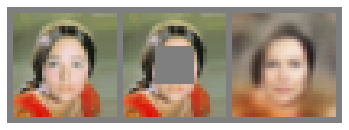

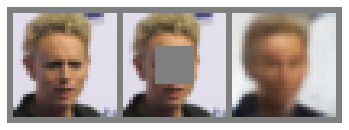

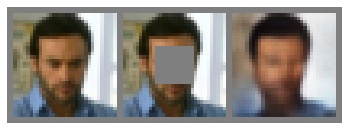

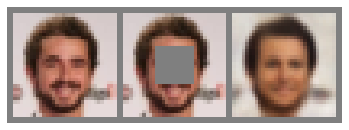

In [ ]:
n_missing_img = 20
images = torch.stack(dataset[:n_missing_img][0], dim=0)
mask = torch.ones(dataset.height, dataset.width, dtype=torch.bool)

for i in range(10, 22):
    for j in range(10, 22):
        mask[i, j] = False

_ = pgd.reconstruct(images, mask)

# Generating synthetic images

To generate synthetic images that resemble those in the data set, we use `PGD.synthesize_images(...)`. To set the type of aggregate posterior approximation applied in the image generation, use the optional `approx_type` argument:

* `approx_type='gaussian'`: A Gaussian distribution (fitted using the sample mean and covariance).
* `approx_type='gmm'`: A Gaussian mixture model with the number of components specified by the `n_components` argument (fitted using the EM algorithm).

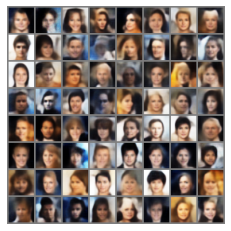

In [ ]:
 _ = pgd.synthesize_images(n=64, approx_type='gmm', n_components=100)